The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

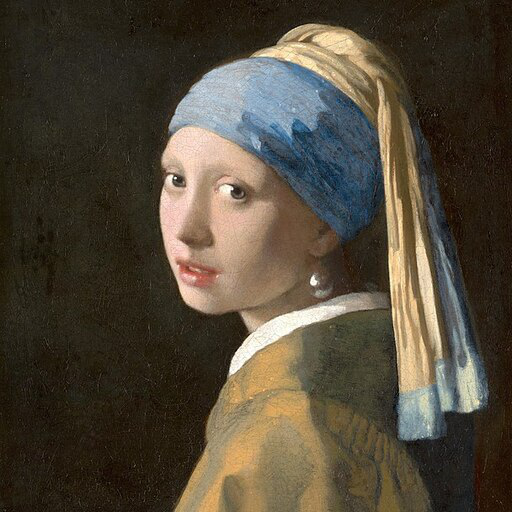

In [1]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

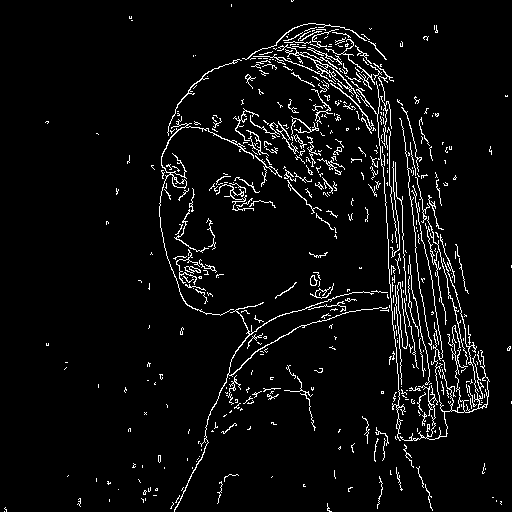

In [2]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [3]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

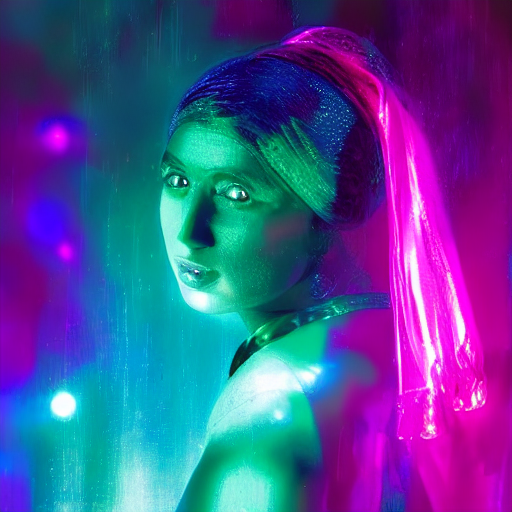

In [4]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/25 [00:00<?, ?it/s]

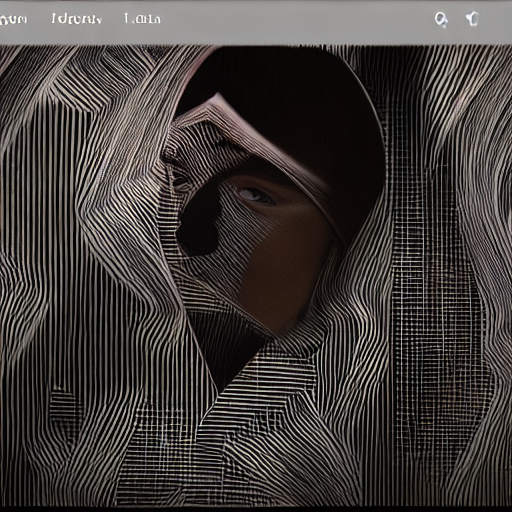

In [6]:
# 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성합니다.
custom_prompt = "a dark theme"  # 사용자 정의 프롬프트
num_inference_steps = 25  # 추론 단계 수 조절

# 이미지를 생성합니다.
custom_image = canny_pipe(
    prompt=custom_prompt, 
    num_inference_steps=num_inference_steps, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
custom_image.save("/aiffel/aiffel/custom_image.png")  

# 생성된 이미지를 출력합니다.
custom_image


인체 자세 감지
Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.

먼저 사람의 전신이 담긴 이미지를 불러오겠습니다.

In [7]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1


     |████████████████████████████████| 44 kB 3.0 MB/s             


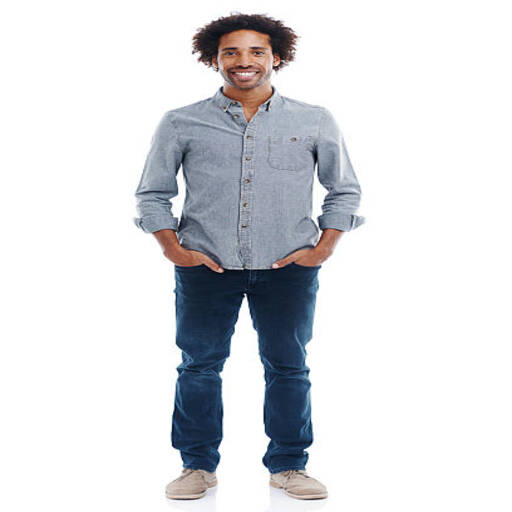

In [19]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


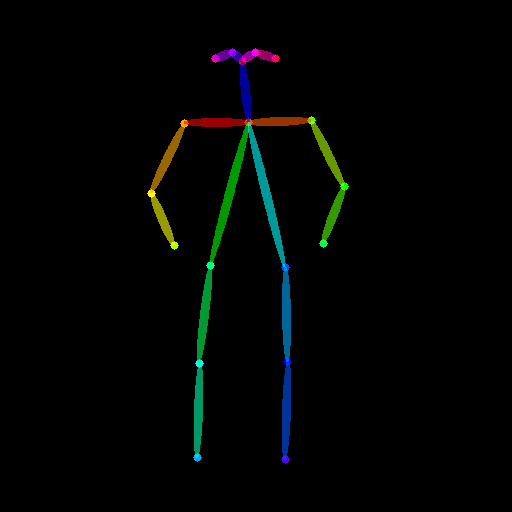

In [20]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [21]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

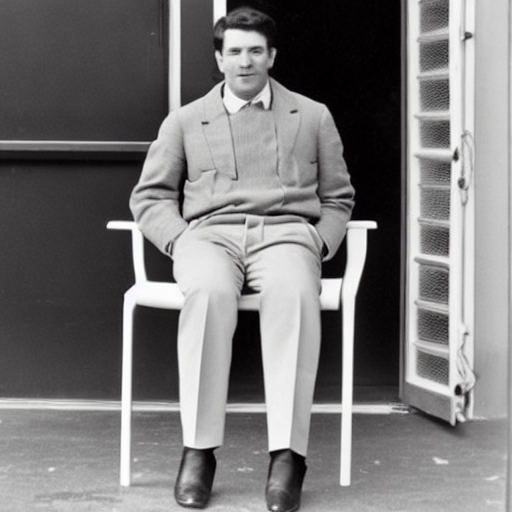

In [22]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt = "sit in a chair"  # 사용자 정의 프롬프트
negative_prompt = "dark, scary themes"  # 부정적인 요소를 제거하는 프롬프트

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=20,  # 추론 단계 수
    generator=generator, 
    image=images
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/30 [00:00<?, ?it/s]

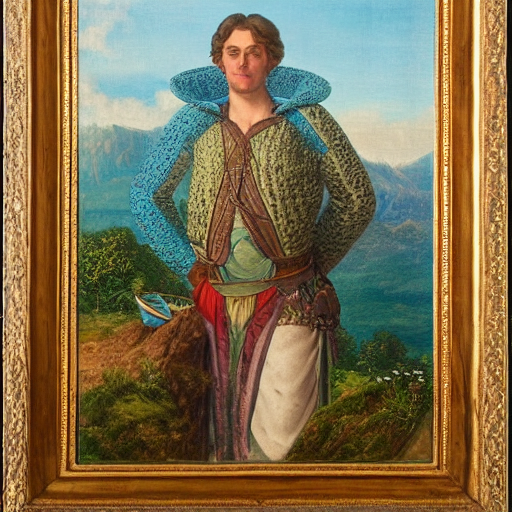

In [23]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
custom_prompt = "a fantasy landscape with mountains and a river"  # 사용자 정의 프롬프트
custom_negative_prompt = "dark, scary themes"  # 부정적인 요소를 제거하는 프롬프트

images = openpose_image

# 이미지를 생성합니다. 
openpose_image2 = openpose_pipe(
    prompt=custom_prompt, 
    negative_prompt=custom_negative_prompt,
    num_inference_steps=30,  # 추론 단계 수
    generator=generator, 
    image=images
    
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image2

Canny 알고리즘을 사용한 윤곽선 검출
먼저 Canny 알고리즘으로 윤곽선을 검출합니다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하세요.

직접 아래의 코드를 작성해 보세요.

In [ ]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image = load_image("your_image_url_or_path_here")


#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)  

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = # [[YOUR CODE]]
canny_image = # [[YOUR CODE]]
canny_image = # [[YOUR CODE]]

Openpose를 사용한 인체 자세 검출

인체 자세를 검출해 줍니다.

In [ ]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image = # [[YOUR CODE]]

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = # [[YOUR CODE]]
openpose_image = # [[YOUR CODE]]

Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달합니다.






In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = # [[YOUR CODE]] 

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = # [[YOUR CODE]]

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt =  # [[YOUR CODE]]
negative_prompt =  # [[YOUR CODE]]

# seed를 지정합니다. 
generator = # [[YOUR CODE]]

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = # [[YOUR CODE]]

# 생성된 이미지를 저장합니다.
image.save("aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image